In [1]:
import numpy as np
import scipy.linalg
from collections import defaultdict, namedtuple, Counter
from itertools import combinations
import numpy as np
import scipy.stats as stats
import sys
from os import listdir
import json
import random
import csv
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [2]:
#dataset_name = 'spark'
#dataset_dir = '../../PhasingFamilies/recomb_spark'
#ped_file = '../../DATA/spark/sparkfam.ped.quads.ped'

dataset_names = ['spark', 'ancestry']
dataset_dirs = ['../../PhasingFamilies/recomb_spark', '../../PhasingFamilies/recomb_ancestry']
ped_files = ['../../DATA/spark/sparkfam.ped.quads.ped', '../../DATA/ancestry/ancestry.ped.quads.ped']

colors = ['#695d46ff', '#ce93d8ff', '#ef6c00ff', '#4db6acff']

interval_chrom1, interval_start_pos1, interval_end_pos1 = '22', 18000000, 22000000
interval_chrom2, interval_start_pos2, interval_end_pos2 = '22', 18000000, 22000000
#dataset_name = 'ihart.ms2'
#dataset_dir = '../../PhasingFamilies/recomb_ihart.ms2'
#ped_file = '../../DATA/ihart.ms2/ihart.ped.quads.ped'

#dataset_name = 'mssng'
#dataset_dir = '../../PhasingFamilies/recomb_mssng'
#ped_file = '../../DATA/mssng/mssng.ped.quads.ped'

num_trials = 1000

def pull_ibd(dataset_name, dataset_dir, ped_file, na):

    # pull phenotype data
    sample_to_affected, sample_to_sex = dict(), dict()
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            sample_to_sex[pieces[1]] = pieces[4]
            sample_to_sex[pieces[3]] = '2'
            sample_to_sex[pieces[2]] = '1'
            sample_to_affected[pieces[1]] = pieces[5]

    sibpairs = []
    sibpair_keys = set()
    with open('%s/sibpairs.json' % dataset_dir, 'r') as f:
        for sibpair in json.load(f):
            sib_key = (sibpair['sibling1'], sibpair['sibling2'])
            if sib_key not in sibpair_keys:
                sibpairs.append(sibpair)
                sibpair_keys.add(sib_key)
                sibpair_keys.add((sib_key[1], sib_key[0]))

    for sibpair in sibpairs:
        sibpair['num_affected'] = int(sample_to_affected[sibpair['sibling1']]=='2') + int(sample_to_affected[sibpair['sibling2']]=='2')

    if na == 3:
        sibpairs = [x for x in sibpairs if (x['num_affected']>0)]
    else:
        sibpairs = [x for x in sibpairs if (x['num_affected']==na)]
    num_sibpairs = len(sibpairs)


    is_pat_match1 = np.load('../permutation_tests/%s.chr%s.%d-%d.%d.is_pat_match.npy' % (dataset_name, interval_chrom1, interval_start_pos1, interval_end_pos1, na))
    intervals1 = np.load('../permutation_tests/%s.chr%s.%d-%d.%d.intervals.npy' % (dataset_name, interval_chrom1, interval_start_pos1, interval_end_pos1, na))
    is_mat_match2 = np.load('../permutation_tests/%s.chr%s.%d-%d.%d.is_mat_match.npy' % (dataset_name, interval_chrom2, interval_start_pos2, interval_end_pos2, na))
    intervals2 = np.load('../permutation_tests/%s.chr%s.%d-%d.%d.intervals.npy' % (dataset_name, interval_chrom2, interval_start_pos2, interval_end_pos2, na))

    interval_lengths1 = intervals1[1, :] - intervals1[0, :]
    is_pat_ibd = np.sign(is_pat_match1.dot(interval_lengths1))
    print(np.sum(is_pat_ibd==1), np.sum(is_pat_ibd==-1))

    interval_lengths2 = intervals2[1, :] - intervals2[0, :]
    is_mat_ibd = np.sign(is_mat_match2.dot(interval_lengths2))
    print(np.sum(is_mat_ibd==1), np.sum(is_mat_ibd==-1))

    print(np.sum((is_mat_ibd==1) & (is_pat_ibd==1)),
          np.sum((is_mat_ibd==1) & (is_pat_ibd==-1)),
          np.sum((is_mat_ibd==-1) & (is_pat_ibd==1)),
          np.sum((is_mat_ibd==-1) & (is_pat_ibd==-1)),
          np.sum(~((is_mat_ibd==1) & (is_pat_ibd==1))))
    print(stats.chi2_contingency([[np.sum((is_mat_ibd==1) & (is_pat_ibd==1)),
          np.sum((is_mat_ibd==1) & (is_pat_ibd==-1))],
                                 [np.sum((is_mat_ibd==-1) & (is_pat_ibd==1)),
          np.sum((is_mat_ibd==-1) & (is_pat_ibd==-1))]]))
    return is_mat_ibd, is_pat_ibd, sibpairs

is_mat_ibd_spark2, is_pat_ibd_spark2, sibpairs_spark2 = pull_ibd(dataset_names[0], dataset_dirs[0], ped_files[0], 2)
is_mat_ibd_ancestry2, is_pat_ibd_ancestry2, sibpairs_ancestry2 = pull_ibd(dataset_names[1], dataset_dirs[1], ped_files[1], 2)
is_mat_ibd_spark1, is_pat_ibd_spark1, sibpairs_spark1 = pull_ibd(dataset_names[0], dataset_dirs[0], ped_files[0], 1)
is_mat_ibd_ancestry1, is_pat_ibd_ancestry1, sibpairs_ancestry1 = pull_ibd(dataset_names[1], dataset_dirs[1], ped_files[1], 1)             
                     

740 726
750 716
388 362 352 364 1078
(0.8687098367932532, 0.3513127280989716, 1, array([[378.58117326, 371.41882674],
       [361.41882674, 354.58117326]]))
11 16
11 16
5 6 6 10 22
(0.00021791064049586273, 0.9882222181111512, 1, array([[4.48148148, 6.51851852],
       [6.51851852, 9.48148148]]))
2644 2654
2657 2642
1317 1340 1327 1314 3982
(0.21781086121375443, 0.6407130186073133, 1, array([[1325.99244998, 1331.00755002],
       [1318.00755002, 1322.99244998]]))


FileNotFoundError: [Errno 2] No such file or directory: '../permutation_tests/ancestry.chr22.18000000-22000000.1.is_pat_match.npy'

In [ ]:
def plotbar(has_ibd_anc, no_ibd_anc, has_ibd_spark, no_ibd_spark, offset=0, color=colors[2], label=None):
    anc_p = has_ibd_anc/(has_ibd_anc+no_ibd_anc)
    anc_lb, anc_ub = sm.stats.proportion_confint(has_ibd_anc, (has_ibd_anc+no_ibd_anc),
                                                      alpha=0.05, method='agresti_coull')

    spark_p = has_ibd_spark/(has_ibd_spark+no_ibd_spark)
    spark_lb, spark_ub = sm.stats.proportion_confint(has_ibd_spark, (has_ibd_spark+no_ibd_spark),
                                                     alpha=0.05, method='agresti_coull')
    
    plt.bar([0+offset, 1+offset], [anc_p, spark_p], width=0.3, color=color, label=label)
    plt.errorbar([0+offset, 1+offset], [anc_p, spark_p], 
                 yerr=[[anc_p-anc_lb, spark_p-spark_lb], 
                       [anc_ub-anc_p, spark_ub-spark_p]], 
                 color='black', linestyle='', capsize=5)


NameError: name 'plotbar' is not defined

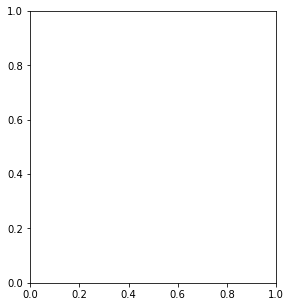

In [3]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plotbar(np.sum(is_mat_ibd_ancestry2==1), np.sum(is_mat_ibd_ancestry2==-1),
        np.sum(is_mat_ibd_spark2==1), np.sum(is_mat_ibd_spark2==-1), color=colors[2], label='aut-aut')

plotbar(np.sum(is_mat_ibd_ancestry1==1), np.sum(is_mat_ibd_ancestry1==-1),
        np.sum(is_mat_ibd_spark1==1), np.sum(is_mat_ibd_spark1==-1), offset=0.35, color=colors[3], label='aut-nt')

plt.axhline(0.5, color='black', linestyle='--')
plt.ylabel('Fraction Sibpairs with IBD', fontsize=16)
plt.xticks([0.175, 1.175], ['KidsFirst', 'SPARK'], fontsize=16)
plt.ylim([0, 1.1])
plt.title('Maternal IBD in 19p13.3 Region', fontsize=16)
plt.text(1, 0.65, '+', fontsize=20, ha='center', va='center')
plt.legend(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 3, 2)
plotbar(np.sum(is_pat_ibd_ancestry2==1), np.sum(is_pat_ibd_ancestry2==-1),
        np.sum(is_pat_ibd_spark2==1), np.sum(is_pat_ibd_spark2==-1), color=colors[2], label='aut-aut')

plotbar(np.sum(is_pat_ibd_ancestry1==1), np.sum(is_pat_ibd_ancestry1==-1),
        np.sum(is_pat_ibd_spark1==1), np.sum(is_pat_ibd_spark1==-1), offset=0.35, color=colors[3], label='aut-nt')

plt.axhline(0.5, color='black', linestyle='--')
plt.xticks([0.175, 1.175], ['KidsFirst', 'SPARK'], fontsize=16)
plt.ylim([0, 1.1])
plt.yticks([])
plt.title('Paternal IBD in 7p22 Region', fontsize=16)
plt.legend(fontsize=16)


plt.subplot(1, 3, 3)
plotbar(np.sum((is_mat_ibd_ancestry2==1) & (is_pat_ibd_ancestry2==1)), 
        np.sum((is_mat_ibd_ancestry2==-1) | (is_pat_ibd_ancestry2==-1)),
        np.sum((is_mat_ibd_spark2==1) & (is_pat_ibd_spark2==1)), 
        np.sum((is_mat_ibd_spark2==-1) | (is_pat_ibd_spark2==-1),), color=colors[2], label='aut-aut')

plotbar(np.sum((is_mat_ibd_ancestry1==1) & (is_pat_ibd_ancestry1==1)), 
        np.sum((is_mat_ibd_ancestry1==-1) | (is_pat_ibd_ancestry1==-1)),
        np.sum((is_mat_ibd_spark1==1) & (is_pat_ibd_spark1==1)), 
        np.sum((is_mat_ibd_spark1==-1) | (is_pat_ibd_spark1==-1)), offset=0.35, color=colors[3], label='aut-nt')

plt.axhline(0.25, color='black', linestyle='--')
plt.xticks([0.175, 1.175], ['KidsFirst', 'SPARK'], fontsize=16)
plt.ylim([0, 1.1])
plt.yticks([])
plt.title('Maternal IBD in 19p13.3 Region and\nPaternal IBD in 7p22 Region', fontsize=16)
plt.text(1, 0.35, '**', fontsize=20, ha='center', va='center')
plt.legend(fontsize=16)

plt.tight_layout()
plt.show()

In [4]:
def check_pvalue(is_mat_ibd, is_pat_ibd, sibpairs):

    # take into account sibling structure across quads
    individuals = sorted(set([x['sibling1'] for x in sibpairs] + [x['sibling2'] for x in sibpairs]))
    ind_to_index = dict([(x, i) for i, x in enumerate(individuals)])
    sibling1_indices = np.array([ind_to_index[x['sibling1']] for x in sibpairs])
    sibling2_indices = np.array([ind_to_index[x['sibling2']] for x in sibpairs])

    A = np.random.randint(0, high=2, size=(num_trials+1, len(individuals), 2))
    X1 = (A[:, sibling1_indices, 0] == A[:, sibling2_indices, 0]).astype(int)
    X2 = (A[:, sibling1_indices, 1] == A[:, sibling2_indices, 1]).astype(int)

    # randomly flip IBD in sibpairs
    #X1 = np.random.randint(0, high=2, size=(num_trials+1, len(sibpairs)))
    #X2 = np.random.randint(0, high=2, size=(num_trials+1, len(sibpairs)))

    X1[X1==0] = -1
    X2[X2==0] = -1

    # first entry is actual IBD relationships
    X1[0, :] = 1
    X2[0, :] = 1

    # now make X1 and X2 the IBD-phen relationships
    is_discordant = np.array([sibpair['num_affected']==1 for sibpair in sibpairs])
    X1[:, is_discordant] = -X1[:, is_discordant]
    X2[:, is_discordant] = -X2[:, is_discordant]

    print('ready')

    # trial, interval, mat/pat
    
    rand_pvalue_mat = np.sum((np.multiply(X2, np.tile(is_mat_ibd, (X2.shape[0], 1)))==1), axis=1)
    
    rand_pvalue_pat = np.sum((np.multiply(X1, np.tile(is_pat_ibd, (X1.shape[0], 1)))==1), axis=1)
    
    rand_pvalue_both = np.sum((np.multiply(X1, np.tile(is_pat_ibd, (X1.shape[0], 1)))==1) & \
                         (np.multiply(X2, np.tile(is_mat_ibd, (X2.shape[0], 1)))==1), axis=1)

    print('mat', np.sum(rand_pvalue_mat[1:] >= rand_pvalue_mat[0])/num_trials)
    print('pat', np.sum(rand_pvalue_pat[1:] >= rand_pvalue_pat[0])/num_trials)
    print('both', np.sum(rand_pvalue_both[1:] >= rand_pvalue_both[0])/num_trials)
    
print('ancestry2')
check_pvalue(is_mat_ibd_ancestry2, is_pat_ibd_ancestry2, sibpairs_ancestry2)
print('spark2')
check_pvalue(is_mat_ibd_spark2, is_pat_ibd_spark2, sibpairs_spark2)

ancestry2
ready
mat 0.865
pat 0.864
both 0.842
spark2
ready
mat 0.196
pat 0.37
both 0.11


In [5]:
# SPARK 0.007
# MSSNG 0.317
# iHART 0.644
# ancestry 0.0


# SPARK1 0.846
# ancestry1 0.163


# Look at spark phenotype

In [33]:
#dataset_name = 'spark'
#dataset_dir = '../../PhasingFamilies/recomb_spark'
#ped_file = '../../DATA/spark/sparkfam.ped.quads.ped'

dataset_name = 'ihart.ms2'
dataset_dir = '../../PhasingFamilies/recomb_ihart.ms2'
ped_file = '../../DATA/ihart.ms2/ihart.ped.quads.ped'

na = 2

sample_to_affected, sample_to_sex = dict(), dict()
with open(ped_file, 'r') as f:
	for line in f:
		pieces = line.strip().split('\t')
		sample_to_sex[pieces[1]] = pieces[4]
		sample_to_sex[pieces[3]] = '2'
		sample_to_sex[pieces[2]] = '1'
		sample_to_affected[pieces[1]] = pieces[5]

sibpairs = []
sibpair_keys = set()
with open('%s/sibpairs.json' % dataset_dir, 'r') as f:
	for sibpair in json.load(f):
		sib_key = (sibpair['sibling1'], sibpair['sibling2'])
		if sib_key not in sibpair_keys:
			sibpairs.append(sibpair)
			sibpair_keys.add(sib_key)
			sibpair_keys.add((sib_key[1], sib_key[0]))
            
for sibpair in sibpairs:
	sibpair['num_affected_diag'] = int(sample_to_affected[sibpair['sibling1']]=='2') + int(sample_to_affected[sibpair['sibling2']]=='2')

            
if na == 3:
	sibpairs = [x for x in sibpairs]
else:
	sibpairs = [x for x in sibpairs if (x['num_affected_diag']==na)]
num_sibpairs = len(sibpairs)
print('sibpairs', num_sibpairs)

sibpairs 1045


In [34]:
is_mat_match1 = np.load('../permutation_tests/%s.chr%s.%d-%d.%d.is_mat_match.npy' % (dataset_name, interval_chrom1, interval_start_pos1, interval_end_pos1, na))
is_pat_match1 = np.load('../permutation_tests/%s.chr%s.%d-%d.%d.is_pat_match.npy' % (dataset_name, interval_chrom1, interval_start_pos1, interval_end_pos1, na))
intervals1 = np.load('../permutation_tests/%s.chr%s.%d-%d.%d.intervals.npy' % (dataset_name, interval_chrom1, interval_start_pos1, interval_end_pos1, na))
is_mat_match2 = np.load('../permutation_tests/%s.chr%s.%d-%d.%d.is_mat_match.npy' % (dataset_name, interval_chrom2, interval_start_pos2, interval_end_pos2, na))
is_pat_match2 = np.load('../permutation_tests/%s.chr%s.%d-%d.%d.is_pat_match.npy' % (dataset_name, interval_chrom2, interval_start_pos2, interval_end_pos2, na))
intervals2 = np.load('../permutation_tests/%s.chr%s.%d-%d.%d.intervals.npy' % (dataset_name, interval_chrom2, interval_start_pos2, interval_end_pos2, na))

interval_lengths1 = intervals1[1, :] - intervals1[0, :]
is_pat_ibd = np.sign(is_pat_match1.dot(interval_lengths1))
print(np.sum(is_pat_ibd==1), np.sum(is_pat_ibd==-1))

interval_lengths2 = intervals2[1, :] - intervals2[0, :]
is_mat_ibd = np.sign(is_mat_match2.dot(interval_lengths2))
print(np.sum(is_mat_ibd==1), np.sum(is_mat_ibd==-1))

#is_of_interest = (is_mat_ibd==1) & (is_pat_ibd==1)
#is_of_interest = (is_mat_ibd==1)
#is_of_interest = (is_pat_ibd==1)
is_of_interest = np.hstack(((is_mat_ibd==1), (is_pat_ibd==1)))
print(is_of_interest.shape)

print(np.sum(is_of_interest))


501 544
574 471
(2090,)
1075


In [42]:
individuals = sorted(set([x['sibling1'] for x in sibpairs] + [x['sibling2'] for x in sibpairs]))
ind_to_index = dict([(x, i) for i, x in enumerate(individuals)])
sibling1_indices = np.array([ind_to_index[x['sibling1']] for x in sibpairs])
sibling2_indices = np.array([ind_to_index[x['sibling2']] for x in sibpairs])

A = np.random.randint(0, high=2, size=(num_trials, len(individuals), 2))
X1 = (A[:, sibling1_indices, 0] == A[:, sibling2_indices, 0]).astype(int)
X2 = (A[:, sibling1_indices, 1] == A[:, sibling2_indices, 1]).astype(int)

X1[X1==0] = -1
X2[X2==0] = -1

#rand_of_interest = (np.multiply(X1, np.tile(is_pat_ibd, (X1.shape[0], 1)))==1) & \
#                    (np.multiply(X2, np.tile(is_mat_ibd, (X2.shape[0], 1)))==1)

#rand_of_interest = (np.multiply(X1, np.tile(is_pat_ibd, (X1.shape[0], 1)))==1)
#rand_of_interest = (np.multiply(X2, np.tile(is_mat_ibd, (X2.shape[0], 1)))==1)
rand_of_interest = np.hstack(((np.multiply(X1, np.tile(is_pat_ibd, (X1.shape[0], 1)))==1),
                    (np.multiply(X2, np.tile(is_mat_ibd, (X2.shape[0], 1)))==1)))

print(rand_of_interest.shape)
print(rand_of_interest)

(1000, 2090)
[[ True False False ... False False  True]
 [False False  True ...  True False  True]
 [False False False ...  True False False]
 ...
 [False  True False ... False  True  True]
 [False  True  True ...  True  True  True]
 [ True False False ... False  True  True]]


In [41]:
chi2_rand = np.zeros((num_trials, 41))
chi2_true = np.zeros((41,))

ps = np.zeros((41, 2))
bounds = np.zeros((41, 2))

for phen_index in range(41):
    print(phen_index+1, end=' ')
    
    if phen_index < 40:
        sample_to_affected = dict()
        with open('../../PhasingFamilies/phenotypes/spark_v5/spark_v5-scq-prep.csv', 'r') as f:
            reader = csv.reader(f)
            for pieces in reader:
                phen = pieces[13+phen_index]
                if phen=='1.0' or phen=='0.0':
                    sample_to_affected[pieces[2]] = 1 if phen =='1.0' else 0

        aut_response = [0]*2 + [1]*6 + [0] + [1]*9 + [0]*22

        for sibpair in sibpairs:
            if (sibpair['sibling1'] not in sample_to_affected) or (sibpair['sibling2'] not in sample_to_affected):
                sibpair['num_affected'] = -1
            else:
                 sibpair['num_affected'] = int(sample_to_affected[sibpair['sibling1']]==aut_response[phen_index]) + int(sample_to_affected[sibpair['sibling2']]==aut_response[phen_index])
    else:
        for sibpair in sibpairs:
            sibpair['num_affected'] = sibpair['num_affected_diag']
    
    num_affected = np.array([sibpair['num_affected'] for sibpair in sibpairs])
    num_affected = np.hstack((num_affected, num_affected))
                
    #print(Counter([sibpair['num_affected'] for sibpair in sibpairs]))
    try:
        c = [[np.sum((num_affected==2) & is_of_interest),
              np.sum((num_affected==2) & ~is_of_interest)],
             [np.sum((num_affected!=2) & is_of_interest),
              np.sum((num_affected!=2) & ~is_of_interest)]]
        chi2_true[phen_index] = stats.chi2_contingency(c)[0]
        pvalue = stats.chi2_contingency(c)[1]
        pvalue2 = stats.binom_test(np.sum((num_affected==2) & is_of_interest), np.sum((num_affected==2)), p=0.25)
        ps[phen_index, 0] = np.sum((num_affected==2) & is_of_interest)/np.sum(num_affected==2)
        ps[phen_index, 1] = np.sum((num_affected!=2) & is_of_interest)/np.sum(num_affected!=2)
        bounds[phen_index, :] = sm.stats.proportion_confint(np.sum((num_affected==2) & is_of_interest), 
                                                            np.sum(num_affected==2),
                                                      alpha=0.05, method='agresti_coull')
        if pvalue<0.05 or phen_index==40:
            print(pvalue, pvalue*40, pvalue2, pvalue2*40, c)
            print(np.sum((num_affected==2) & is_of_interest)/np.sum(is_of_interest),
                  np.sum((num_affected==2) & ~is_of_interest)/np.sum(~is_of_interest))
            
    except ValueError:
        pass
    
    for i in range(num_trials):
        try:
            c = [[np.sum((num_affected==2) & rand_of_interest[i, :]),
                  np.sum((num_affected==2) & ~rand_of_interest[i, :])],
                 [np.sum((num_affected!=2) & rand_of_interest[i, :]),
                  np.sum((num_affected!=2) & ~rand_of_interest[i, :])]]
            chi2_rand[i, phen_index] = stats.chi2_contingency(c)[0]  
        except:
            pass
        


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 

KeyboardInterrupt: 

In [37]:
max_index = np.argmax(np.abs(chi2_true))
max_value = np.max(np.abs(chi2_true))
max_values = np.max(np.abs(chi2_rand), axis=1)
print(max_index+1, np.sum(max_values>= max_value)/num_trials)

1 1.0


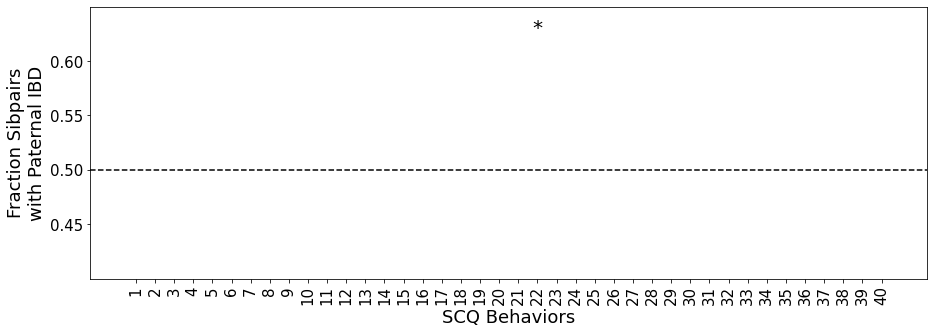

In [38]:
plt.figure(figsize=(15, 5))
plt.bar(np.arange(1, 41), ps[:40, 0], color=[colors[2] if (bounds[i, 0]>0.5 or bounds[i, 1]<0.5) else colors[3] for i in range(40)])
plt.errorbar(np.arange(1, 41), ps[:40, 0], 
                 yerr=[ps[:40, 0]-bounds[:40, 0], bounds[:40, 1]-ps[:40, 0]], 
                 color='black', linestyle='', capsize=5)

#plt.bar(np.arange(1, 42)+0.35, ps[:, 1], width=0.3)
plt.axhline(0.5, color='black', linestyle='--')
plt.ylim([0.4, 0.65])
plt.xticks(np.arange(1, 41), ['' if (bounds[i-1, 0]<=0.5 and bounds[i-1, 1]>=0.5) else '%d' % i for i in range(1, 41)], rotation=90, fontsize=15)
plt.text(22, 0.63, '*', fontsize=20, ha='center', va='center')
plt.xlabel('SCQ Behaviors', fontsize=18)
plt.yticks(np.arange(0.45, 0.65, 0.05), fontsize=15)
plt.ylabel('Fraction Sibpairs\nwith Paternal IBD', fontsize=18)

plt.show()

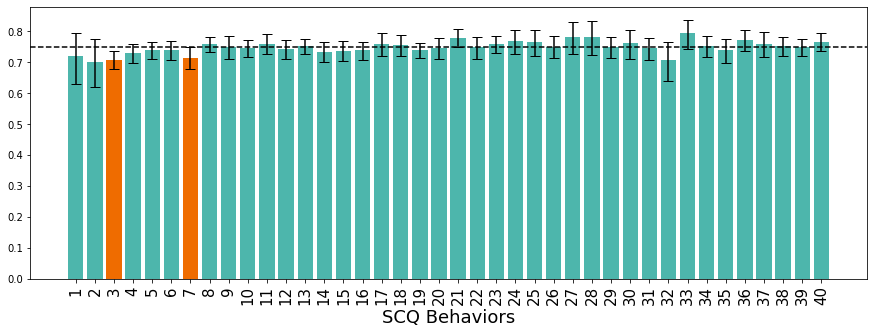

In [18]:
plt.figure(figsize=(15, 5))
plt.bar(np.arange(1, 41), ps[:40, 0], color=[colors[2] if (bounds[i, 0]>0.75 or bounds[i, 1]<0.75) else colors[3] for i in range(40)])
plt.errorbar(np.arange(1, 41), ps[:40, 0], 
                 yerr=[ps[:40, 0]-bounds[:40, 0], bounds[:40, 1]-ps[:40, 0]], 
                 color='black', linestyle='', capsize=5)

#plt.bar(np.arange(1, 42)+0.35, ps[:, 1], width=0.3)
plt.axhline(0.75, color='black', linestyle='--')
#plt.ylim([0.45, 0.65])
plt.xticks(np.arange(1, 41), ['' if (bounds[i-1, 0]<=0.25 and bounds[i-1, 1]>=0.75) else '%d' % i for i in range(1, 41)], rotation=90, fontsize=15)
#plt.text(22, 0.63, '*', fontsize=20, ha='center', va='center')
plt.xlabel('SCQ Behaviors', fontsize=18)
#plt.yticks(np.arange(0.45, 0.65, 0.05), fontsize=15)

plt.show()

In [206]:
phen_index = 21
print(phen_index+1)
    
sample_to_affected = dict()
with open('../../PhasingFamilies/phenotypes/spark_v5/spark_v5-scq-prep.csv', 'r') as f:
    reader = csv.reader(f)
    for pieces in reader:
        phen = pieces[13+phen_index]
        if phen=='1.0' or phen=='0.0':
            sample_to_affected[pieces[2]] = 1 if phen =='1.0' else 0

aut_response = [0]*2 + [1]*6 + [0] + [1]*9 + [0]*22

for sibpair in sibpairs:
    if (sibpair['sibling1'] not in sample_to_affected) or (sibpair['sibling2'] not in sample_to_affected):
        sibpair['num_affected'] = -1
    else:
        sibpair['num_affected'] = int(sample_to_affected[sibpair['sibling1']]==aut_response[phen_index]) + int(sample_to_affected[sibpair['sibling2']]==aut_response[phen_index])
num_affected = np.array([sibpair['num_affected'] for sibpair in sibpairs])
    

22


In [ ]:
plt.bar(np.arange(3), )